In [1]:
from mdcrow import MDCrow
import os

In [2]:
descriptive_prompt_5 = "Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Tell me how many residues are in the chains and beta sheets. 3. Simulate for 1 ps at 300 K. 4. Compute the RMSD. 5. Compute the radius of gyration over time."
non_descriptive_prompt_5 = "Simulate 1LYZ for 1 ps at 300 K. Tell me how many residues are in the chains and beta sheets, and compute the RMSD and radius of gyration of the simulation."

In [3]:
llm_model = "claude-3-5-sonnet-20241022"
tools = "all"

In [4]:
#todays date and time
import datetime
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")
print("date:",date)
time = now.strftime("%H:%M:%S")
print("time:",time)

date: 2025-01-16
time: 12:35:12


# descriptive prompt

In [5]:
agent_1 = MDCrow(agent_type="Structured", model=llm_model, top_k_tools=tools)

In [6]:
agent_1.run(descriptive_prompt_5)

Thought: Let's break this down into steps. First, I need to download the PDB file 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file, I'll get information about the residues and beta sheets using GetTurnsBetaSheetsHelices. First, I need to get the UniProt ID and primary accession number.

Action:
```
{
    "action": "GetUniprotID",
    "action_input": "1LYZ"
}
```

Thought: I'll continue with getting the structural information about beta sheets and residues using the UniProt ID we just obtained.

Action:
```
{
    "action": "GetTurnsBetaSheetsHelices",
    "action_input": {
        "query": "P17897",
        "primary_accession": "P17897"
    }
}
```

Thought: Since we didn't get the structural information from UniProt directly, let's analyze the structure using the downloaded PDB file. We'll first get a summary of the structure, then proceed with the simulation and analysis.



({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [7]:
registry = agent_1.path_registry
print("ckpt_dir:",os.path.basename(registry.ckpt_dir))
paths_and_descriptions = registry.list_path_names_and_descriptions()
print("\n".join(paths_and_descriptions.split(",")))

ckpt_dir: ckpt_108
Files found in registry: 1LYZ_123518: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_123518
 1LYZ_123538: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_123542: Initial positions for simulation sim0_123542
 sim0_123542: Basic Simulation of Protein 1LYZ_123538
 rec0_123545: Simulation trajectory for protein 1LYZ_123538 and simulation sim0_123542
 rec1_123545: Simulation state log for protein 1LYZ_123538 and simulation sim0_123542
 rec2_123545: Simulation pdb frames for protein 1LYZ_123538 and simulation sim0_123542
 rmsd_123542: RMSD for 123542
 fig0_123912: RMSD plot for 123542
 rgy_rec0_123545: Radii of gyration per frame for rec0_123545
 fig0_123915: Plot of radii of gyration over time for rec0_123545


In [8]:
import re
import os
match = re.search(r"rec0_\d+", paths_and_descriptions)
traj_id = match.group(0)
traj_path = registry.get_mapped_path(traj_id)
match = re.search(r"top_sim0_\d+", paths_and_descriptions)
top_id = match.group(0)
top_path = registry.get_mapped_path(top_id)
assert os.path.exists(traj_path), "Trajectory file doesn't exist"
assert os.path.exists(top_path), "Topology file doesn't exist"
assert traj_path.endswith(".dcd")
assert top_path.endswith(".pdb")
print(f"It's asserted that file paths for {traj_id} and {top_id} exist")

It's asserted that file paths for rec0_123545 and top_sim0_123542 exist


In [9]:
# this checks DSSP for the first frame, change to the last frame if needed
import mdtraj as md

traj_path = registry.get_mapped_path(traj_id)
top_path = registry.get_mapped_path(top_id)
traj = md.load(traj_path, top=top_path)[0] # first frame

secondary_structure = md.compute_dssp(traj,simplified=True)[0]
print("Number of residues in total: ",traj.n_residues)
print("Number of chains: ",traj.n_chains)
print("Number of residues in sheets: ",len([i for i in secondary_structure if i == 'E']))
print("Number of residues in helices: ",len([i for i in secondary_structure if i == 'H']))
print("Number of residues in coils: ",len([i for i in secondary_structure if i == 'C']))

Number of residues in total:  6917
Number of chains:  3
Number of residues in sheets:  14
Number of residues in helices:  53
Number of residues in coils:  62


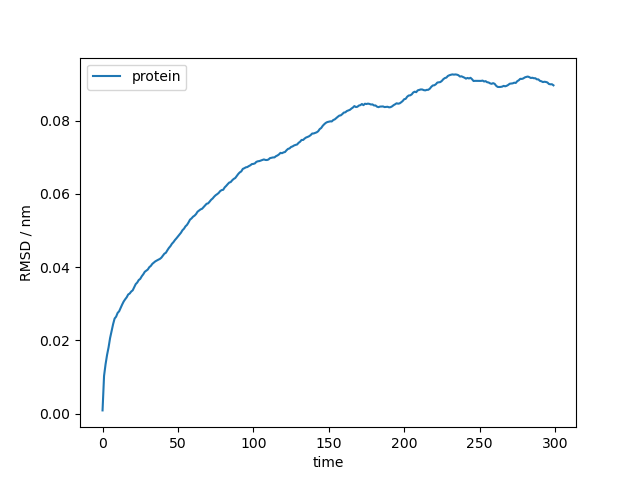

In [10]:
from IPython.display import Image
matches = re.findall(r"fig0_\d+", paths_and_descriptions)
fig_id1 = matches[0]
fig_path1 = registry.get_mapped_path(fig_id1)
assert os.path.exists(fig_path1), f"This figure {fig_id1} does not exist."
Image(filename=fig_path1)

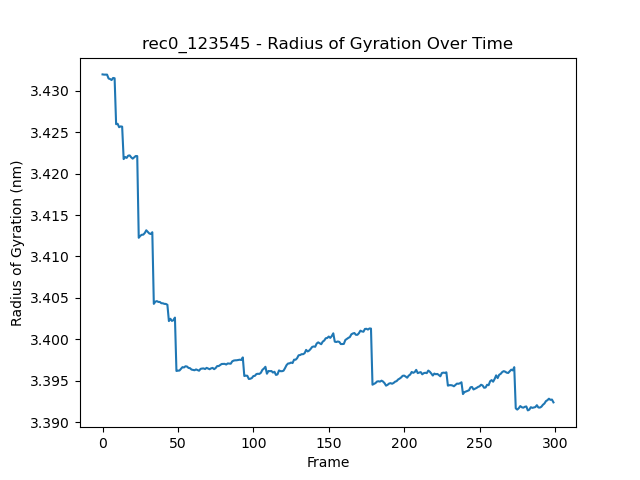

In [11]:
fig_id2 = matches[1]
fig_path2 = registry.get_mapped_path(fig_id2)
assert os.path.exists(fig_path2), f"This figure {fig_id2} does not exist."
Image(filename=fig_path2)

# non-descriptive prompt

In [13]:
agent_2 = MDCrow(agent_type="Structured", model=llm_model, top_k_tools=tools)

In [14]:
agent_2.run(non_descriptive_prompt_5)

Thought: Let me break this down into steps:
1. First, I need to download the PDB file for 1LYZ
2. Then set up and run a simulation
3. After the simulation, I'll analyze the structure and dynamics

Let's start by downloading the PDB file.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file, I'll set up and run a simulation for 1 ps at 300 K. I'll use the SetUpandRunFunction tool with appropriate parameters.

Action:
```
{
    "action": "SetUpandRunFunction",
    "action_input": {
        "pdb_id": "1LYZ_123927",
        "forcefield_files": ["amber14-all.xml", "amber14/tip3pfb.xml"],
        "save": true,
        "system_params": {
            "nonbondedMethod": "PME",
            "nonbondedCutoff": "1.0 * nanometers",
            "constraints": "HBonds",
            "rigidWater": true,
            "ewaldErrorTolerance": 0.0005,
            "constraintTolerance": 0.000001,
            

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

In [15]:
registry = agent_2.path_registry
print("ckpt_dir:",os.path.basename(registry.ckpt_dir))
paths_and_descriptions = registry.list_path_names_and_descriptions()
print("\n".join(paths_and_descriptions.split(",")))

ckpt_dir: ckpt_109
Files found in registry: 1LYZ_123927: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_123927
 1LYZ_123938: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_123942: Initial positions for simulation sim0_123942
 sim0_123942: Basic Simulation of Protein 1LYZ_123938
 rec0_123945: Simulation trajectory for protein 1LYZ_123938 and simulation sim0_123942
 rec1_123945: Simulation state log for protein 1LYZ_123938 and simulation sim0_123942
 rec2_123945: Simulation pdb frames for protein 1LYZ_123938 and simulation sim0_123942


In [16]:
import re
import os
match = re.search(r"rec0_\d+", paths_and_descriptions)
traj_id = match.group(0)
traj_path = registry.get_mapped_path(traj_id)
match = re.search(r"top_sim0_\d+", paths_and_descriptions)
top_id = match.group(0)
top_path = registry.get_mapped_path(top_id)
assert os.path.exists(traj_path), "Trajectory file doesn't exist"
assert os.path.exists(top_path), "Topology file doesn't exist"
assert traj_path.endswith(".dcd")
assert top_path.endswith(".pdb")
print(f"It's asserted that file paths for {traj_id} and {top_id} exist")

It's asserted that file paths for rec0_123945 and top_sim0_123942 exist


In [22]:
# # this checks DSSP for the first frame, change to the last frame if needed
# import mdtraj as md

# traj_path = registry.get_mapped_path(traj_id)
# top_path = registry.get_mapped_path(top_id)
# traj = md.load(traj_path, top=top_path)[0] # first frame

# secondary_structure = md.compute_dssp(traj,simplified=True)[0]
# print("Number of residues in total: ",traj.n_residues)
# print("Number of chains: ",traj.n_chains)
# print("Number of residues in sheets: ",len([i for i in secondary_structure if i == 'E']))
# print("Number of residues in helices: ",len([i for i in secondary_structure if i == 'H']))
# print("Number of residues in coils: ",len([i for i in secondary_structure if i == 'C']))

In [19]:
# from IPython.display import Image
# matches = re.findall(r"fig0_\d+", paths_and_descriptions)
# fig_id1 = matches[0]
# fig_path1 = registry.get_mapped_path(fig_id1)
# assert os.path.exists(fig_path1), f"This figure {fig_id1} does not exist."
# Image(filename=fig_path1)

In [20]:
# fig_id2 = matches[1]
# fig_path2 = registry.get_mapped_path(fig_id2)
# assert os.path.exists(fig_path2), f"This figure {fig_id2} does not exist."
# Image(filename=fig_path2)

In [21]:
# match = re.search(r"rgy_rec0_\d+", paths_and_descriptions)
# rgy_id = match.group(0)
# rgy_path = registry.get_mapped_path(rgy_id)
# assert os.path.exists(rgy_path), "RGy file doesn't exist"
# with open(rgy_path, "r") as f:
#     lines = f.read().split("\n")
#     for i in range(5):
#         print(lines[i])